# Datascope Take Home Challenge: Chicago Train Analysis

## Introduction

This challenge uses data representative of the number of people to go through the turnstiles at every Chicago "L" station since 2001. For more information on the dataset, check out the [readme](https://data.cityofchicago.org/api/assets/CCAFA078-D8FC-43EE-8FAA-28007103DA2E?download=true) documentation. 

For more information on the work and findings in this notebook, please see the executive summary attached with the submission.

## Imports

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

%matplotlib inline

## Download and Organize Data

First, download the [dataset](https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f) as a CSV file and move it to your working directory. Then upload the data to your notebook as a Pandas dataframe. Here I've converted the "date" column into a datetime object to simplify exploratory data analysis and visualization moving forward. 

In [23]:
# find way to scrape off website and load using function
def create_df(file):
    """Input a csv file of L rides and return dataframe with parsed dates in 3rd column"""
    return pd.read_csv(file, parse_dates = [2], infer_datetime_format = True)

In [24]:
# create data frame
df = create_df("CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")

In [22]:
# basic info on df, observe that the date column now has datetime values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826894 entries, 0 to 826893
Data columns (total 5 columns):
station_id     826894 non-null int64
stationname    826894 non-null object
date           826894 non-null datetime64[ns]
daytype        826894 non-null object
rides          826894 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 31.5+ MB


In [124]:
# snapshot of dataframe
df.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,2001-01-01,U,290
1,40020,Harlem-Lake,2001-01-01,U,633
2,40030,Pulaski-Lake,2001-01-01,U,483
3,40040,Quincy/Wells,2001-01-01,U,374
4,40050,Davis,2001-01-01,U,804


In [65]:
# sanity check that there are no negative values for rides
assert (df.rides < 0).sum() == 0 

Note that there are stations that show zero rides on a given day. The readme indicates bus stations are included in the data set. Stations with zero rides are likely bus stations. If necessary, bus stations can be removed by locating a separate dataset of all bus station names and removing those name from the "stationname" column.

## Warm Up Questions

### Question 1

**Which stop has the highest average ridership per day, and what is it?**

For this question I created a pivot table and set each unique date as the index with the total daily rides per station as columns. I then average the rides per station and choose five with the highest averages. The analysis below shows the Clark/Lake station has the highest average rides at 13663.540513 per day. This makes sense because Clark/Lake is a popular station in the loop that transfers to 6 lines. For comparision, I included the top five stations as well.

It's important to note that this average is taken over the past 16 years and doesn't capture the nuances of changes over time. We are also looking at every day available in the dataset rather than analzying the changes on weekdays vs weekends, holidays and fluctuations in seasonality. These are important details to analze to find meaningful insights.

In [50]:
# pivot table of the sum of rides per day per station
pt_date = df.pivot_table(index="date", columns="stationname", 
                         values="rides", aggfunc="sum")

In [70]:
# view pivot table
pt_date.head()

stationname,18th,35-Bronzeville-IIT,35th/Archer,43rd,47th-Dan Ryan,47th-South Elevated,51st,54th/Cermak,63rd-Dan Ryan,69th,...,Washington/Dearborn,Washington/State,Washington/Wells,Wellington,Western-Brown,Western-Cermak,Western-Forest Park,Western-Orange,Western/Milwaukee,Wilson
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.0,448.0,318.0,211.0,787.0,427.0,364.0,0.0,1366.0,2366.0,...,1039.0,1181.0,259.0,270.0,715.0,0.0,318.0,460.0,621.0,1449.0
2001-01-02,813.0,1195.0,1654.0,640.0,1902.0,1116.0,913.0,1404.0,3047.0,5732.0,...,7757.0,6507.0,6788.0,2194.0,3194.0,418.0,702.0,2627.0,2504.0,3519.0
2001-01-03,881.0,1357.0,1777.0,713.0,1965.0,1216.0,1071.0,1466.0,3350.0,5977.0,...,8257.0,6783.0,7321.0,2449.0,3272.0,457.0,812.0,2846.0,2601.0,4211.0
2001-01-04,884.0,1389.0,1878.0,695.0,2130.0,1165.0,994.0,1530.0,3371.0,6206.0,...,8303.0,6906.0,7350.0,2548.0,3398.0,478.0,774.0,3086.0,2837.0,4132.0
2001-01-05,925.0,1478.0,1825.0,724.0,2182.0,1349.0,1068.0,1554.0,3456.0,6436.0,...,8482.0,6802.0,6983.0,2466.0,3346.0,505.0,860.0,3073.0,2740.0,4144.0


In [58]:
# create a series of average daily ridership per station
station_daily_avg = pt_date.mean(axis=0)

In [63]:
# number of stations
len(station_daily_avg)

147

In [91]:
# top station with highest average ridership per day
top_station = station_daily_avg.nlargest(n=1, keep='first')
top_station

stationname
Clark/Lake    13663.540513
dtype: float64

In [67]:
# top five stations with highest average ridership per day
top_five = station_daily_avg.nlargest(n=5, keep='first')

In [71]:
top_five

stationname
Clark/Lake            13663.540513
Lake/State            13304.173404
Chicago/State         12944.953208
95th/Dan Ryan         10868.678022
Belmont-North Main    10440.290384
dtype: float64

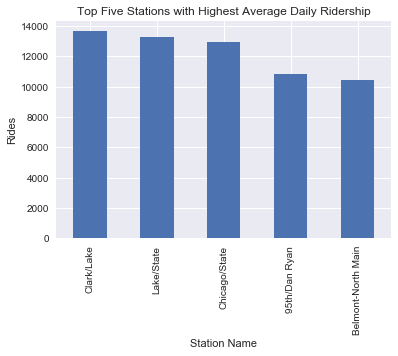

In [89]:
ax = top_five.plot(kind="bar", title = "Top Five Stations with Highest Average Daily Ridership")
ax.set_ylabel("Rides")
ax.set_xlabel("Station Name");

### Question 2

**Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?**

In this dataset, weekdays are indicated with a "W" in the daytype column and holidays are denoted with a "U". I first isolate the weekdays to find the standard deviation in weekday ridership per day. Then I order the dataframe of stations and their standard deviations from highest to lowest. We can see that the Lake/State station has the highest standard deviation per weekday of 4292.931370. 

The standard deviation tells us the spread around the mean. So in the case of the Lake/State station, a high standard deviation tells us that there is a lot of variation in the number of people entering the station. This could be for a number of reasons. For example, the dataset looks at a long time span. It's possible the station grew in popularity over the past 16 years, increasing the variation around the mean. 

In [101]:
# create dataframe with just weekday information

df_weekday = df.loc[df['daytype'] == "W"]

In [102]:
# sanity check that we only have weekday values now

df_weekday["daytype"].value_counts()

W    577803
Name: daytype, dtype: int64

In [108]:
# find standard deviation of rides per station on a weekday

df_weekday_std = df_weekday.groupby('stationname').agg(np.std)

In [111]:
# drop the station_id column

df_weekday_std.drop("station_id", axis=1, inplace= True)

In [112]:
# snapshot of new dataframe

df_weekday_std.head()

,rides
stationname,
18th,415.126490
35-Bronzeville-IIT,751.150281
35th/Archer,442.413740
43rd,187.541908
47th-Dan Ryan,592.460708


In [122]:
# sort stations by highest standard deviation in ridership per weekday

df_weekday_std.sort_values(by = "rides", ascending= False, inplace=True)

In [125]:
# top five stations with highest standard deviation

df_weekday_std.head(5)

,rides
stationname,
Lake/State,4292.931370
Washington/State,3890.640503
Addison-North Main,3289.670003
Clark/Lake,2742.644346
Fullerton,2602.717176


## Challenge Question

Imagine you’re a business owner in Chicago looking to open a new location. Any kind of business will do. In the form of writing, potentially supplemented by sketches (computer-drawn or hand-drawn) and links, we want to see your response to these questions:
- What questions could you potentially explore/answer with this data?
- Ideally, what other data would you gather or combine to learn even more?
- How would you want to see data presented, to make it actionable by you or others?

**Approach**

Before we can choose a location for our client's new business, we should examine a few qualities outside of rides per station. Ideally I'd like to analyze demographic, income, property value and crime data across the city to help identify potential areas for the business that align with our client's consumer base. However, this is outside the scope of the project. Given the time constraints of this project, I'll pull in a dataset with farmer's market information by zip code. Given our client's business, this is most relevant. With this dataset, we can identify train stops near farmer's markets. Additionally, because our client is mainly focused on weekends and springtime, I'll create a subset of the data reflecting these times. 

Once the data is appropriately filtered, I'll choose the stop five stations with the most ridership to drive foot traffic. These stations are then visualized on a map for our client. 

[Source](https://catalog.data.gov/dataset/farmers-markets-2015) of farmer's market dataset


**Notes to self**

Pull in long/lat of each station. From here we can get the zip codes and connect with census data to reach target demographic. 
potentially search for more specific turnstile data that shows hours. we want to target shoppers after business hours and on weekends/holidays.
Look at most recent years.
Want to open business during peak ridership season
prediction for this?
Really only need past 2/3 years
Poperty values?
How much space is needed? May not be feasable start in the neighborhood with the highest income
Map top five most viable stations on Carto?


MAP_ID = station_id

In [228]:
df.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,2001-01-01,U,290
1,40020,Harlem-Lake,2001-01-01,U,633
2,40030,Pulaski-Lake,2001-01-01,U,483
3,40040,Quincy/Wells,2001-01-01,U,374
4,40050,Davis,2001-01-01,U,804


In [229]:
# bring in a second dataset that includes station IDs and their lattitude and longitutde coordinates

df_stations = create_df("CTA_-_System_Information_-_List_of__L__Stops.csv")

In [230]:
# snapshot of dataset with lat/long locations

df_stations.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [231]:
# the dataframe contains multiple values for one MAP_ID. 
# The duplicates must be deleted to prevent duplicating ride values when dataframes are merged

df_stations = df_stations.drop_duplicates(subset="MAP_ID")

In [278]:
# remove parentheses from Location values to prepare them for api

df_stations["Location"] = df_stations['Location'].map(lambda x: str(x)[1:-1])

In [281]:
# convert Location column to string

df_stations['Location'] = df_stations['Location'].astype(str)

In [362]:
def zip_code_locator(df):
    """takes input of dataframe and uses latitude longitude column in dataframe to find zipcode
    returns dataframe with zipcode column"""
    zip_codes = []
    for index, row in df.iterrows():
        #print(row.latitude, row.longitude)
        geolocator = Nominatim()
        #print(row.Location)
        location = geolocator.reverse(row.Location, timeout=10)
        results = location.raw
        results["address"]["postcode"]
        zip_codes.append(results["address"]["postcode"])
    df["zip_codes"] = zip_codes
    return df
    

In [288]:
# create new dataframe with zip codes

df_zip_codes = zip_code_locator(df_stations)

In [290]:
df_zip_codes.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,station_id,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location,zip_codes
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"41.857908, -87.669147",60608
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"41.829353, -87.680622",60632
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"41.831677, -87.625826",60609
6,30246,S,43rd (63rd-bound),43rd,43rd (Green Line),41270,True,False,False,True,False,False,False,False,False,False,"41.816462, -87.619021",60653
8,30025,S,51st (63rd-bound),51st,51st (Green Line),40130,True,False,False,True,False,False,False,False,False,False,"41.80209, -87.618487",60615


Note that the *MAP_ID* column in *df_stations* is the same as the *station_id* column in *df*. To merge the two datasets, we can rename *MAP_ID* to *station_id* and merge on this column. 

In [291]:
# rename MAP_ID in the df_zip_codes dataframe to station_id

df_zip_codes.rename(columns={'MAP_ID':'station_id'}, inplace=True)

In [292]:
# merge the two dataframe on the station_id column. New master dataframe is df2

df2 = pd.merge(df, df_zip_codes, on='station_id')

In [293]:
# drop a few unnecessary columns from df2

df2.drop(["RED","BLUE","G","BRN","P","Pexp","Y","Pnk","O","ADA"], axis=1, inplace=True)

Now that we have the zip codes for each station, we can use this information to connect train stations with census data. Below I upload a dataset that contains information on farmer's markets locations around the city. 

In [300]:
# open taxes csv into dataframe

df_markets = create_df("Farmers_Markets_-_2015.csv")

In [348]:
df_markets.head()

,LOCATION,INTERSECTION,DAY,START TIME,END TIME,START DATE,END DATE,WEBSITE,TYPE,LINK ACCEPTED,LATITUDE,LONGITUDE,MAP
0,Pilsen Night Market,18th St. & Blue Island Ave.,Wednesday,4:00 PM,8:00 PM,07/08/2015,09/02/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.857866,-87.661159,"(41.8578656, -87.6611589)"
1,Columbus Park,Harrison & Central,Tuesday,2:00 PM,7:00 PM,06/30/2015,09/29/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.872636,-87.765010,"(41.87263635, -87.76501013)"
2,Northcenter,Lincoln & Belle Plaine,Saturday,7:00 AM,1:00 PM,06/13/2015,10/24/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.955976,-87.679102,"(41.95597563, -87.67910157)"
3,Printers Row,Dearborn & Polk,Saturday,7:00 AM,1:00 PM,06/20/2015,10/24/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.872282,-87.629130,"(41.87228245, -87.6291295)"
4,Garfield Park (Monthly on 2nd Saturdays),Lake & Kedzie,Saturday,10:00 AM,1:00 PM,06/13/2015,10/10/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.884870,-87.706234,"(41.8848705, -87.7062339)"


In [349]:
# remove parentheses from Location values to prepare them for api

df_markets["MAP"] = df_markets['MAP'].map(lambda x: str(x)[1:-1])

In [351]:
# convert Location column to string

df_markets['MAP'] = df_markets['MAP'].astype(str)

In [353]:
# rename MAPS column to location so it works with zip_code_locator

df_markets.rename(columns={'MAP':'Location'}, inplace=True)

In [361]:
# drop row with bad values

df_markets = df_markets.drop(df_markets.index[16])

In [363]:
# add zip codes to farmer's market dataframe

df_market_zip_codes = zip_code_locator(df_markets)

In [385]:
df_market_zip_codes.head(3)

,LOCATION,INTERSECTION,DAY,START TIME,END TIME,START DATE,END DATE,WEBSITE,TYPE,LINK ACCEPTED,LATITUDE,LONGITUDE,Location,zip_codes
0,Pilsen Night Market,18th St. & Blue Island Ave.,Wednesday,4:00 PM,8:00 PM,07/08/2015,09/02/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.857866,-87.661159,"41.8578656, -87.6611589",60608
1,Columbus Park,Harrison & Central,Tuesday,2:00 PM,7:00 PM,06/30/2015,09/29/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.872636,-87.765010,"41.87263635, -87.76501013",60644
2,Northcenter,Lincoln & Belle Plaine,Saturday,7:00 AM,1:00 PM,06/13/2015,10/24/2015,http://chicagofarmersmarkets.us,Neighborhood,Y,41.955976,-87.679102,"41.95597563, -87.67910157",60618


In [366]:
# make a list of zip codes with farmer's markets

market_zip_codes = df_market_zip_codes["zip_codes"].tolist()

In [370]:
# create a column with "True" if zip code contains and farmers market and "false" otherwise

df2["has_market"] = df2["zip_codes"].isin(market_zip_codes)

In [376]:
# create a subset of dataframe for train stops with farmer's markets.

df_cta_market = df2.loc[df2['has_market'] == True]

In [383]:
# really, only the past few years are indicative of current train ridership, 
# so shorten dataframe to past ~5 years

df3 = df_cta_market[(df_cta_market['date'] > '2011-01-01')]

In [386]:
df3.head()

,station_id,stationname,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,Location,zip_codes,has_market
15284,40030,Pulaski-Lake,2011-01-02,U,841,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),"41.885412, -87.725404",60644,True
15285,40030,Pulaski-Lake,2011-01-03,W,1955,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),"41.885412, -87.725404",60644,True
15286,40030,Pulaski-Lake,2011-01-04,W,1953,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),"41.885412, -87.725404",60644,True
15287,40030,Pulaski-Lake,2011-01-05,W,1974,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),"41.885412, -87.725404",60644,True
15288,40030,Pulaski-Lake,2011-01-06,W,1897,30005,E,Pulaski (63rd-bound),Pulaski,Pulaski (Green Line),"41.885412, -87.725404",60644,True


In [389]:
# create subset of dataframe for just weekends and holidays

df3 = df3.loc[df3['daytype'] != "W"]

In [391]:
# create a month column

df3['month'] = pd.DatetimeIndex(df3['date']).month


In [397]:
# create column that identifies spring months

df3["spring"] = df3["month"].isin([3,4,5])

In [399]:
# create subset of dataframe for just spring months

df3 = df3.loc[df3['spring'] == True]

Our dataframe now represents train stops near farmers markets for spring months on the weekends. This isolates the target time and locations for our client. Now we want to find the stations with the highest ridership to ideally bring more foot traffic to the bakery. Below I identify the top 5 stations with the highest weekend ridership.

In [402]:
# pivot table of the sum of rides per day per station

pt_date2 = df3.pivot_table(index="date", columns="stationname", 
                         values="rides", aggfunc="sum")

In [404]:
# create a series of average daily ridership per station

station_ridership_avg = pt_date2.mean(axis=0)

In [406]:
# top five stations with highest average ridership per day
top_five = station_ridership_avg.nlargest(n=5, keep='first')

In [426]:
list_top_five = list(top_five.index)

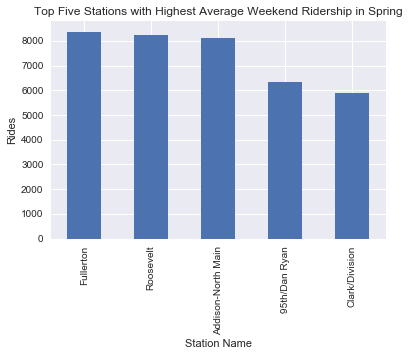

In [427]:
# graph top five stations

ax = top_five.plot(kind="bar", title = "Top Five Stations with Highest Average Weekend Ridership in Spring")
ax.set_ylabel("Rides")
ax.set_xlabel("Station Name");

**Map the top five stations**

In [428]:
# need separate longitude and lat for mapping
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in df3['Location']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
df3['latitude'] = lat
df3['longitude'] = lon

In [429]:
df3["top_stations"] = df3["stationname"].isin(list_top_five)

In [430]:
df_top_stations = df3.loc[df3["top_stations"] == True]

In [432]:
# new dataframe of top stations

df_top_stations.head()

,station_id,stationname,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,Location,zip_codes,has_market,month,spring,latitude,longitude,top_stations
248012,40450,95th/Dan Ryan,2011-03-05,A,7359,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),"41.722377, -87.624342",60620,True,3,True,41.722377,-87.624342,True
248013,40450,95th/Dan Ryan,2011-03-06,U,5641,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),"41.722377, -87.624342",60620,True,3,True,41.722377,-87.624342,True
248019,40450,95th/Dan Ryan,2011-03-12,A,7815,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),"41.722377, -87.624342",60620,True,3,True,41.722377,-87.624342,True
248020,40450,95th/Dan Ryan,2011-03-13,U,5710,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),"41.722377, -87.624342",60620,True,3,True,41.722377,-87.624342,True
248026,40450,95th/Dan Ryan,2011-03-19,A,8144,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),"41.722377, -87.624342",60620,True,3,True,41.722377,-87.624342,True


In [436]:
# convert to csv for mapping

df_top_stations.to_csv("top_stations")

To Do:

Next steps- if CTA stop has a farmer's market, put true, else false in main df
isolate zip codes with farmer's markets
find high traffic weekend stations (assume buisness owner knows most people shop at bakery on weekends)
choose top 5 stations
visualize in carto
graph station traffic
owner wants to kick off in the spring b/c that's when farmer's markets become popular- look at spring data